In [1]:
import polars as ps
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.regularizers import l2


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


### Reading the nessecary files

In [4]:
#-----------already_done_running---------------
# df = ps.read_parquet('C:/Users/diyac/AIandBioProject/ts.parquet')
# pandas_df = df.to_pandas()
# events = pd.read_csv("C:/Users/diyac/AIandBioProject/train_events.csv")
# pandas_df['series_id'].value_counts()
# train_events_csv = pd.read_csv('C:/Users/diyac/Downloads/child-mind-institute-detect-sleep-states-20231119T201923Z-001/train_events.csv')

### Creating the new csv using the zipper function 

In [3]:
def fillValue(i, flag, val, merged_df_patient):
    merged_df_patient.iloc[i,9]=val

def generate_merged(newdf, pandas_df, csv_file):    
    newdf['label'] = newdf['event']
    awake_mask = (newdf['label'] == 'onset') | (newdf['label'] == 'wakeup')
    newdf['y_target'] = awake_mask.cumsum()
    newdf.loc[newdf['label'] == 'onset', 'y_target'] = 0
    newdf['y_target'] = newdf['y_target'].fillna(method='ffill')
    flag=1
    for i in range(len(newdf)):
        #print("current i value : "+str(i))
        if newdf.iloc[i,8]=='onset' or newdf.iloc[i,8]=='wakeup':
            if newdf.iloc[i,8]=='onset':
                flag=flag*(-1)
                fillValue(i,flag,1,newdf)
            if newdf.iloc[i,8]=='wakeup':
                flag=flag*(-1)
                fillValue(i,flag,0,newdf)

        elif flag==1:
            fillValue(i,flag,0,newdf)
        else:
            fillValue(i, flag,1,newdf)
    return newdf    

def merging_patients(series_id_list): 
    columns = ['series_id', 'step', 'timestamp_x', 'anglez', 'enmo', 'night', 'event', 'timestamp_y', 'label', 'y_target']
    patient_log = pd.DataFrame(columns=columns)
    for i in range(len(series_id_list)): 
        patient_train_events=train_events_csv[train_events_csv['series_id'] == series_id_list[i]]
        patient_df = pandas_df[pandas_df['series_id'] == series_id_list[i]]
        patient_train_events=patient_train_events.dropna()
        patient_train_events['step'] = patient_train_events['step'].astype(int)
        merged_df_patient = pd.merge(patient_df, patient_train_events, on=['series_id', 'step'], how='left')
        merged_df_patient =generate_merged(merged_df_patient, patient_df, patient_train_events)
        print(i,": done")  
        patient_log=pd.concat([patient_log, merged_df_patient], ignore_index=True)
    return patient_log


In [6]:
#----------already_created_the edit file
# np.random.seed(0)
# unique_series_ids  = pandas_df['series_id'].value_counts().index.to_numpy()
# randomly_selected_names = np.random.choice(unique_series_ids, size=3, replace=False)
# print("Randomly selected names:", randomly_selected_names)
# shortlisted_patients = merging_patients(randomly_selected_names)


Randomly selected names: ['1b92be89db4c' '655f19eabf1e' '5c55a5e717d6']
0 : done
1 : done
2 : done


In [9]:
shortlisted_patients.to_csv("C:/Users/diyac/Detect_Sleep_States/patientLog.csv")

In [19]:
train_dataset = pd.read_csv("C:/Users/diyac/Detect_Sleep_States/patientLog.csv")
train_dataset = train_dataset.drop(['Unnamed: 0', 'timestamp_x', 'night', 'event', 'timestamp_y', 'label'], axis=1)
train_dataset


,series_id,step,anglez,enmo,y_target
0,1b92be89db4c,0,87.1277,0.0033,0
1,1b92be89db4c,1,88.1777,0.0091,0
2,1b92be89db4c,2,88.2099,0.0030,0
3,1b92be89db4c,3,88.1331,0.0017,0
4,1b92be89db4c,4,87.9545,0.0015,0
...,...,...,...,...,...
1172875,5c55a5e717d6,397255,-0.4428,0.0068,0
1172876,5c55a5e717d6,397256,-1.2413,0.0009,0
1172877,5c55a5e717d6,397257,-1.7075,0.0009,0
1172878,5c55a5e717d6,397258,-0.3891,0.0025,0


In [26]:
# Separate features (X) and target (Y)
X = train_dataset.drop(columns=['y_target', 'series_id', 'step'])
Y = train_dataset['y_target']

### Baseline MLP Model

In [21]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_test, Y_test))

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/5
29322/29322 [==============================] - 70s 2ms/step - loss: 0.4559 - accuracy: 0.7719 - val_loss: 0.4238 - val_accuracy: 0.7927
Epoch 2/5
29322/29322 [==============================] - 68s 2ms/step - loss: 0.4332 - accuracy: 0.7905 - val_loss: 0.4193 - val_accuracy: 0.7930
Epoch 3/5
29322/29322 [==============================] - 68s 2ms/step - loss: 0.4346 - accuracy: 0.7913 - val_loss: 0.4134 - val_accuracy: 0.8016
Epoch 4/5
29322/29322 [==============================] - 68s 2ms/step - loss: 0.4357 - accuracy: 0.7911 - val_loss: 0.4133 - val_accuracy: 0.8059
Epoch 5/5
7331/7331 [==============================] - 11s 2ms/step - loss: 0.4156 - accuracy: 0.8069
Test Loss: 0.4156, Test Accuracy: 80.69%


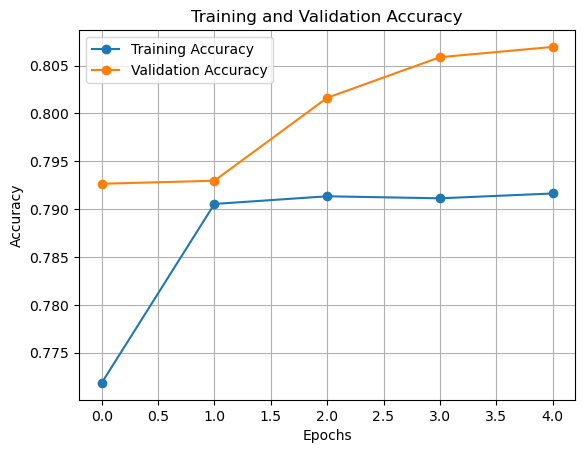

In [33]:
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


### Basic LSTM Model

In [29]:
X_array = X.to_numpy()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_array)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)


model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


optimizer = Adam(learning_rate=0.01, epsilon=1e-7)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history1 = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/5
29322/29322 [==============================] - 226s 8ms/step - loss: 0.4714 - accuracy: 0.7587 - val_loss: 0.4346 - val_accuracy: 0.7752
Epoch 2/5
29322/29322 [==============================] - 224s 8ms/step - loss: 0.4456 - accuracy: 0.7836 - val_loss: 0.4253 - val_accuracy: 0.7936
Epoch 3/5
29322/29322 [==============================] - 222s 8ms/step - loss: 0.4422 - accuracy: 0.7876 - val_loss: 0.4168 - val_accuracy: 0.8073
Epoch 4/5
29322/29322 [==============================] - 169s 6ms/step - loss: 0.4409 - accuracy: 0.7891 - val_loss: 0.4243 - val_accuracy: 0.7949
Epoch 5/5
7331/7331 [==============================] - 16s 2ms/step - loss: 0.4159 - accuracy: 0.8018
Test Loss: 0.4159, Test Accuracy: 80.18%


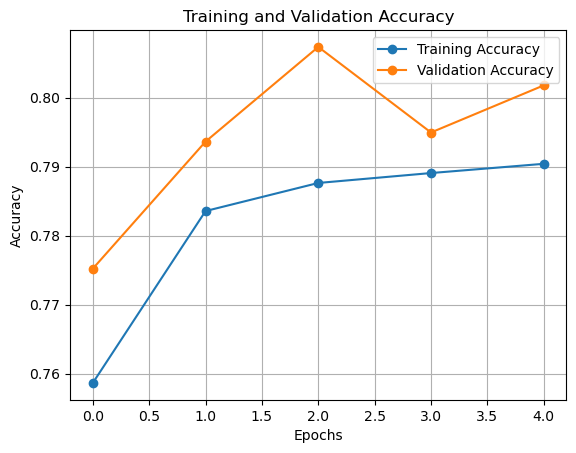

In [34]:
plt.plot(history1.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

### Improved LSTM model

In [32]:
X_array = X.to_numpy()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_array)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)


model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', return_sequences=True))  # Additional LSTM layer
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))  # Another LSTM layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001, epsilon=1e-7)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history2 = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))  # Increased epochs
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10
3666/3666 [==============================] - 50s 12ms/step - loss: 0.5085 - accuracy: 0.7409 - val_loss: 0.4302 - val_accuracy: 0.8016
Epoch 2/10
3666/3666 [==============================] - 44s 12ms/step - loss: 0.4486 - accuracy: 0.7848 - val_loss: 0.4193 - val_accuracy: 0.7994
Epoch 3/10
3666/3666 [==============================] - 42s 12ms/step - loss: 0.4393 - accuracy: 0.7906 - val_loss: 0.4163 - val_accuracy: 0.8001
Epoch 4/10
3666/3666 [==============================] - 44s 12ms/step - loss: 0.4360 - accuracy: 0.7927 - val_loss: 0.4139 - val_accuracy: 0.8004
Epoch 5/10
3666/3666 [==============================] - 42s 12ms/step - loss: 0.4327 - accuracy: 0.7942 - val_loss: 0.4128 - val_accuracy: 0.8006
Epoch 6/10
3666/3666 [==============================] - 42s 11ms/step - loss: 0.4302 - accuracy: 0.7956 - val_loss: 0.4124 - val_accuracy: 0.7984
Epoch 7/10
3666/3666 [==============================] - 39s 11ms/step - loss: 0.4281 - accuracy: 0.7966 - val_loss: 0.4105 -

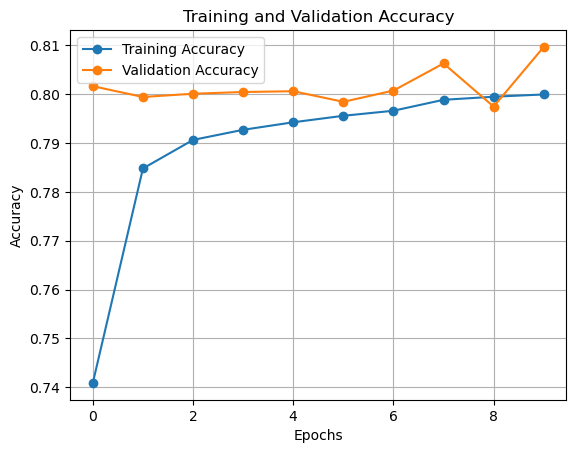

In [35]:
plt.plot(history2.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

### Improved LSTM model with Feature Engineering

In [2]:

def fillValue(i, flag, val, merged_df_patient):
    merged_df_patient.iloc[i, 9] = val

def generate_merged(newdf, pandas_df, csv_file):    
    newdf['label'] = newdf['event']
    awake_mask = (newdf['label'] == 'onset') | (newdf['label'] == 'wakeup')
    newdf['y_target'] = awake_mask.cumsum()
    newdf.loc[newdf['label'] == 'onset', 'y_target'] = 0
    newdf['y_target'] = newdf['y_target'].fillna(method='ffill')
    flag = 1
    for i in range(len(newdf)):
        if newdf.iloc[i, 8] == 'onset' or newdf.iloc[i, 8] == 'wakeup':
            if newdf.iloc[i, 8] == 'onset':
                flag = flag * (-1)
                fillValue(i, flag, 1, newdf)
            if newdf.iloc[i, 8] == 'wakeup':
                flag = flag * (-1)
                fillValue(i, flag, 0, newdf)
        elif flag == 1:
            fillValue(i, flag, 0, newdf)
        else:
            fillValue(i, flag, 1, newdf)
    return newdf

def add_rolling_features(patient_df):
    patient_df['enmo_rolling_mean'] = patient_df.groupby('series_id')['enmo'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    patient_df['enmo_rolling_std'] = patient_df.groupby('series_id')['enmo'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    patient_df['anglez_rolling_mean'] = patient_df.groupby('series_id')['anglez'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    patient_df['anglez_rolling_std'] = patient_df.groupby('series_id')['anglez'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    patient_df['enmo_diff'] = patient_df.groupby('series_id')['enmo'].diff()
    patient_df['anglez_diff'] = patient_df.groupby('series_id')['anglez'].diff()
    patient_df['hour'] = patient_df['timestamp_x'].str.slice(11, 13)
    return patient_df

def merging_patients(series_id_list): 
    columns = ['series_id', 'step', 'timestamp_x', 'anglez', 'enmo', 'night', 'event', 'timestamp_y', 'label', 'y_target']
    patient_log = pd.DataFrame(columns=columns)
    for i in range(len(series_id_list)): 
        patient_train_events = train_events_csv[train_events_csv['series_id'] == series_id_list[i]]
        patient_df = pandas_df[pandas_df['series_id'] == series_id_list[i]]
        patient_train_events = patient_train_events.dropna()
        patient_train_events['step'] = patient_train_events['step'].astype(int)
        merged_df_patient = pd.merge(patient_df, patient_train_events, on=['series_id', 'step'], how='left')
        merged_df_patient = generate_merged(merged_df_patient, patient_df, patient_train_events)
        merged_df_patient = add_rolling_features(merged_df_patient)
        print(f"Series ID: {series_id_list[i]} - Hour Column: {merged_df_patient['hour'].unique()}")  
        patient_log = pd.concat([patient_log, merged_df_patient[['series_id', 'step', 'timestamp_x', 'anglez', 'enmo', 'night', 'event', 'timestamp_y', 'label', 'y_target', 'hour','enmo_rolling_mean','enmo_rolling_std','anglez_rolling_mean','anglez_rolling_std','enmo_diff','anglez_diff']]], ignore_index=True)
    return patient_log



In [3]:
randomseries=['1b92be89db4c', '655f19eabf1e', '5c55a5e717d6']

In [4]:
#train_events_csv=pd.read_csv('/users/abhinandganesh/downloads/child-mind-institute-detect-sleep-states/train_events.csv')
#pandas_df= pd.read_csv('/users/abhinandganesh/downloads/TIMESTAMPINFO.csv')
#pandas_df = pandas_df.iloc[:,1:]

In [10]:
feature_df=merging_patients(randomseries)

Series ID: 1b92be89db4c - Hour Column: ['11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '00'
 '01' '02' '03' '04' '05' '06' '07' '08' '09' '10']
Series ID: 655f19eabf1e - Hour Column: ['13' '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '00' '01' '02'
 '03' '04' '05' '06' '07' '08' '09' '10' '11' '12']
Series ID: 5c55a5e717d6 - Hour Column: ['15' '16' '17' '18' '19' '20' '21' '22' '23' '00' '01' '02' '03' '04'
 '05' '06' '07' '08' '09' '10' '11' '12' '13' '14']


In [ ]:
feature_df.to_csv('/users/abhinandganesh/Detect_Sleep_States/data/higherdim_patientlog.l')

In [24]:
feature_df=feature_df.iloc[1:,:]
dropped_feature_df=feature_df.drop(['event','series_id','step','timestamp_x','night','timestamp_y','label'],axis=1)
dropped_feature_df=dropped_feature_df.dropna()
X=dropped_feature_df[['anglez','enmo','hour','enmo_rolling_std','anglez_rolling_std','enmo_diff','anglez_diff']]
y=dropped_feature_df['y_target']

In [40]:
X_array = X.to_numpy()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_array)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.001, epsilon=1e-7)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10
1833/1833 [==============================] - 8s 4ms/step - loss: 0.2532 - accuracy: 0.9039 - val_loss: 0.1613 - val_accuracy: 0.9395
Epoch 2/10
1833/1833 [==============================] - 8s 4ms/step - loss: 0.1682 - accuracy: 0.9388 - val_loss: 0.1471 - val_accuracy: 0.9441
Epoch 3/10
1833/1833 [==============================] - 8s 4ms/step - loss: 0.1549 - accuracy: 0.9438 - val_loss: 0.1361 - val_accuracy: 0.9480
Epoch 4/10
1833/1833 [==============================] - 8s 4ms/step - loss: 0.1493 - accuracy: 0.9455 - val_loss: 0.1354 - val_accuracy: 0.9488
Epoch 5/10
1833/1833 [==============================] - 8s 4ms/step - loss: 0.1474 - accuracy: 0.9461 - val_loss: 0.1351 - val_accuracy: 0.9478
Epoch 6/10
1833/1833 [==============================] - 8s 4ms/step - loss: 0.1452 - accuracy: 0.9467 - val_loss: 0.1331 - val_accuracy: 0.9484
Epoch 7/10
1833/1833 [==============================] - 8s 4ms/step - loss: 0.1438 - accuracy: 0.9470 - val_loss: 0.1330 - val_accuracy:

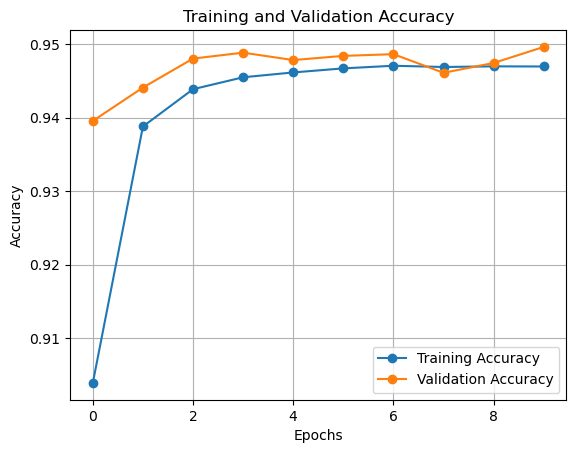

In [41]:
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()